# 2. Traditional ML: Random Forest

## 2.1 Introduction
Before moving on to deeplearning, we will first use traditional Machine Learning techniques. We use a **Random Forest Classifier**.

## 2.2 Feature Engineering
In order to create a good model, we need good features. We will create these features based on the midi file. For processing of the midi file, Pretty-Midi is used. The features that are created are:
- `pitch_range:` Romantic composers tend to use a wider range than Baroque composers
- `rhythm_stability:` Romantic composers tend to use more expressive rhythms, so they wil have a less stable rythm
- `avg_interval:` Romantic composers use larger intervals
- `dynamic_range:` As the piano evolved, more contrast in dynamics was used
- `harmonic_density:` Romantic music tends to be more harmonically dense

In [20]:
import os
import numpy as np
import pandas as pd
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

MIDI_ROOT = '../data/maestro-v3.0.0'
METADATA_PATH = '../data/filtered_maestro.csv'

In [21]:
def extract_features(midi_path):
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)

        notes = pm.instruments[0].notes

        notes.sort(key=lambda x: x.start)

        if len(notes) == 0: return None

        pitches = [n.pitch for n in notes]
        pitch_range = float(np.max(pitches)) - float(np.min(pitches))

        durations = [n.end - n.start for n in notes]
        rhythm_stability = np.std(durations)

        intervals = []
        for i in range(1, len(notes)):
            dist = abs(notes[i].pitch - notes[i-1].pitch)
            intervals.append(dist)
        avg_interval = np.mean(intervals)

        velocities = [n.velocity for n in notes]
        dynamic_range = np.std(velocities)

        piano_roll = pm.get_piano_roll(fs=10)
        polyphony = np.count_nonzero(piano_roll, axis=0)
        active_polyphony = polyphony[polyphony > 0]
        harmonic_density = float(np.mean(active_polyphony)) if len(active_polyphony) > 0 else 0

        return [pitch_range, rhythm_stability, avg_interval, dynamic_range, harmonic_density]

    except ValueError as e:
        return None

In [29]:
df = pd.read_csv(METADATA_PATH)

X = []
y = []
splits = []

for index, row in df.iterrows():
    path = os.path.join(MIDI_ROOT, row['midi_filename'])

    if os.path.exists(path):
        feats = extract_features(path)
        if feats:
            X.append(feats)
            y.append(row['canonical_composer'])
            splits.append(row['split'])

feature_names = [
    'Pitch Range',
    'Rhythm Stability',
    'Avg Interval',
    'Dynamic Range',
    'Harmonic Density'
]

df_features = pd.DataFrame(X, columns=feature_names)
df_features['Composer'] = y
df_features['Split'] = splits

print(f"Shape: {df_features.shape}")
display(df_features.head())

Shape: (809, 7)


,Pitch Range,Rhythm Stability,Avg Interval,Dynamic Range,Harmonic Density,Composer,Split
0,75.0,0.056233,12.932203,16.684430,3.780186,Franz Liszt,train
1,75.0,0.121229,12.940949,16.761929,5.923835,Franz Liszt,train
2,75.0,0.097084,13.133274,19.607130,9.927060,Franz Liszt,train
3,82.0,0.293669,10.289609,15.874305,8.644298,Franz Liszt,train
4,83.0,0.360638,12.564990,22.791820,6.555637,Franz Liszt,train


## 2.3 Plotting Features


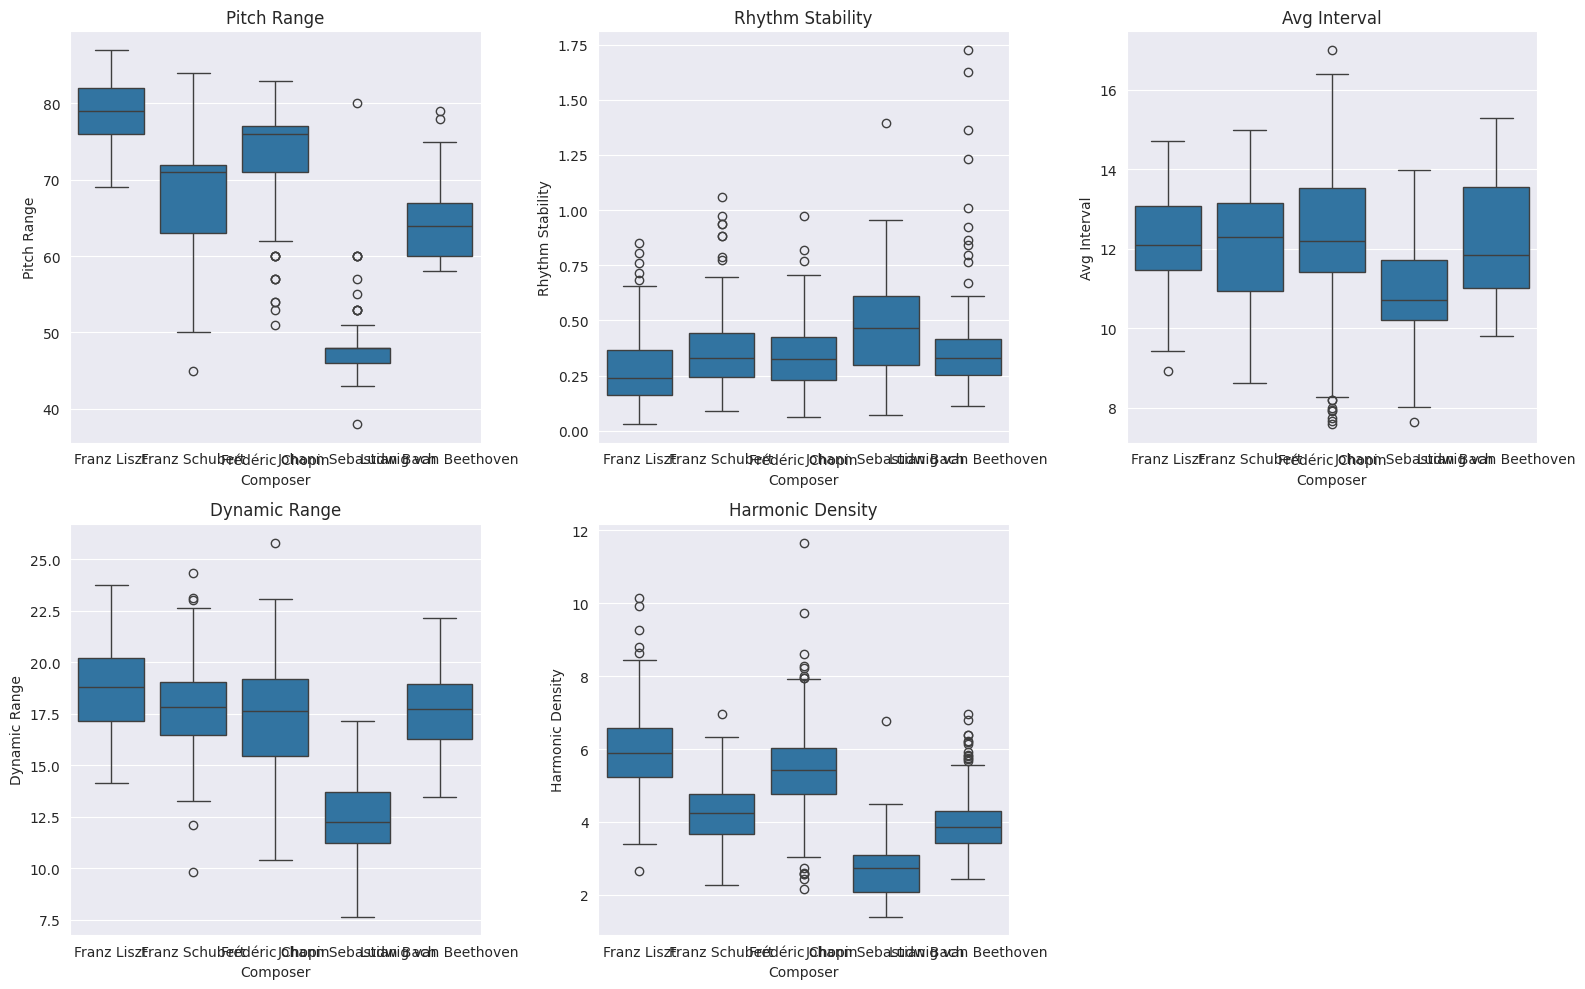

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = [
    'Pitch Range', 'Rhythm Stability',
    'Avg Interval', 'Dynamic Range', 'Harmonic Density'
]

plt.figure(figsize=(16, 10))

for i, col in enumerate(feature_names):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Composer', y=col, data=df_features)
    plt.title(col)

plt.tight_layout()
plt.show()

## 2.4 Analysis of Features

The boxplots show that the features show clear differences between composers, they make sense and follow the hypothesis from above.

- `pitch_range:` Just like expected, there is a clear positive correlation between the pitch range and chronological timeline of the composers.
- `rhythm_stability:` **Bach** has a higher rhythm stability than the other composers, which was expected.
- `avg_interval:` We can clearly see that **Bach** is an outlier and has the lowest average interval. What is surprising is that **Beethoven** has a higher average interval than Liszt. A potential explanation for this is that pieces by Liszt often contain very fast chromatic scales, where the interval between notes is very small. This could drag the average down.
- `dynamic_range:` The dynamic range follows the hypothesis and increases for newer composers.
- `harmonic_density:` Romantic music tends to be more harmonically dense, this is reflected by the dot plot.

## 2.5 Random Forest Model

Training on 621 samples, Testing on 109 samples.
Accuracy 58.72%

Classification Report:
                       precision    recall  f1-score   support

          Franz Liszt       0.81      0.65      0.72        20
       Franz Schubert       0.37      0.48      0.42        23
      Frédéric Chopin       0.53      0.40      0.45        25
Johann Sebastian Bach       1.00      1.00      1.00        17
 Ludwig van Beethoven       0.48      0.54      0.51        24

             accuracy                           0.59       109
            macro avg       0.64      0.61      0.62       109
         weighted avg       0.61      0.59      0.59       109



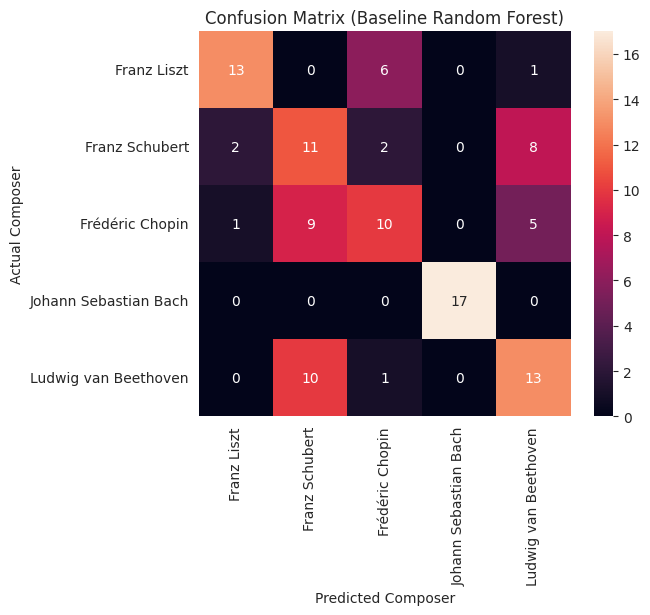


Feature Importance:
Pitch Range         0.428943
Harmonic Density    0.184041
Avg Interval        0.135439
Dynamic Range       0.131690
Rhythm Stability    0.119888
dtype: float64


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

train_data = df_features[df_features['Split'] == 'train']
test_data = df_features[df_features['Split'] == 'test']

X_train = train_data[feature_names]
y_train = train_data['Composer']

X_test = test_data[feature_names]
y_test = test_data['Composer']

print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples.")

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)

print(f"Accuracy {accuracy:.2%}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual Composer')
plt.xlabel('Predicted Composer')
plt.title('Confusion Matrix')
plt.show()

importance = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nFeature Importance:")
print(importance)

### 2.6 Analysis of the model

The Random Forest achieved a **Baseline Accuracy of 56%**. Performance was highly polarized:
-**Success:** **J.S. Bach** was perfectly classified ($F_1$-score: 1.00). This confirms the success in separating Baroque from Romantic styles.
-**Failure:** Romantic composers like **Franz Schubert** ($F_1$: 0.42) and **Frédéric Chopin** ($F_1$: 0.43) struggled significantly.

#### Confusion Matrix Deep Dive
-**Bach Separation:** Bach was never confused with any other composer.
-**Romantic Blending:** Misclassifications were heavily concentrated among the 19th-century composers. For instance, **10 actual Chopin pieces were incorrectly predicted as Franz Schubert**, and **8 actual Liszt pieces were predicted as Frédéric Chopin**. This indicates the simple features fail to capture the subtle differences between these composers.

#### Feature Importance Analysis
The Feature Importance makes sense when we look at the dotplots.
-`pitch_range` was the most important feature (40.9%). This was the dotplot with the clearest difference between composers.
-`harmonic_density` (19.9%) and `dynamic_range` (13.7%) were also strong, which is also clear when we look at the dotplots.

## Conclusion
The model is able to analyse differentiate between composers from different historical periods, especially at detecting pieces from Bach. It struggles with differentiating between different composers from the same period.